# 1. Import libraries to be used in this notebook

In [1]:
import numpy as np # for array manipulation and basic scientific calculation
import xarray as xr # To read NetCDF files
import matplotlib.pyplot as plt # Core library for plotting
from functions.Calc_Emis import Calc_Emis_T # Emission calculation
from scipy.interpolate import griddata # Simple regridding

# 2. Read files

## 2.1. Model output

In [2]:
Filebase_CONUS = '/glade/scratch/tilmes/archive/f.e22.FCcotagsNudged.ne0CONUSne30x8.cesm220.2012-01/atm/hist/f.e22.FCcotagsNudged.ne0CONUSne30x8.cesm220.2012-01.cam.h1.2013-MM.nc'

# Change "MM" to 01~12 for a year calculation
Files_CONUS = [] # empty list for a start
# file list with 12 files
for mm in np.arange(12):
    Files_CONUS.append( Filebase_CONUS.replace('MM',str(mm+1).zfill(2)) )
# read 12 files at once using "mf"dataset
ds_CONUS = xr.open_mfdataset( Files_CONUS ) 


## 2.2. SCRIP file
### SCRIP file has grid information that is needed to calculate area of each grid
### Don't have to read, just locate where the files are

In [3]:
SCRIP_CONUS = '/glade/p/acom/MUSICA/grids/ne0CONUSne30x8/ne0CONUS_ne30x8_np4_SCRIP.nc'

## 5.1. Zonal plot
### For advanced regridding methods, use ESMPy (https://earthsystemmodeling.org/esmpy_doc/release/latest/html/intro.html)

In [36]:

#Function Cell

def SE_ZonalMeridional(Data,Area,input_coords,Regridding_res,**kwargs):  
    """
    This function will be used for calculating area-weighted Zonal/Meridional information
    
    Data: SE data 
    
    Area: Area with similar length as Data
    
    input_coords: Latitude or Longitude coordinates for zonal or meridional info, respectively
    
    Regridding_res: The regular grid resolution for calculating the output means
    
    **kwargs:
        Type: Default to Zonal. Should be changed to Meridional if desired
    
    """
    Type=kwargs.pop('Type','Zonal')
    
    
    # Calculating output_coords
    if Type=='Zonal':
        n = int(180/Regridding_res+1)
        x = np.linspace(-90,90,n)
    elif Type=='Meridional':
        n = int(360/Regridding_res+1)
        x = np.linspace(-180,180,n)    
    else:
        print('ZonalMeridional Error: Type is wrong')
    
      
    # Find the nearest indices for the coords
    output_idx=[]
    for tmp_l in input_coords:
        tmp_data=(x-tmp_l)**2    # distance
        idx=np.where(tmp_data==np.min(tmp_data))[0][0]  # find the index of nearest x
        output_idx.append(int(idx))
    output_idx=np.array(output_idx)    
    
    
    # Calculate the area-weighted means for the ZonalMeridional data
    data=[]
    for idx in range(len(x)):
        tmp=np.where(output_idx==idx)

        tmp_mean=np.nansum(Data[tmp]*Area[tmp])/np.nansum(Area[tmp])

        data.append(tmp_mean)
    data=np.array(data)
     
    return data,x



# 5.1. Calculate regridded data

In [34]:
# Regrid the data for zonal plot to a regular grid with the following resolution
Regridding_res=1.  #in degree


area= ds_CONUS_Jan['area'].values
# PRECL and PRECC are in m/s. 8.64e7 is used to convert m/s to mm/day
PRECC = ds_CONUS_Jan['PRECC'].values* 8.64e7
PRECL = ds_CONUS_Jan['PRECL'].values* 8.64e7

    
    
Zmean_PRECC,Z_coord=SE_ZonalMeridional(PRECC,area,lat,Regridding_res) 
Zmean_PRECL,Z_coord=SE_ZonalMeridional(PRECL,area,lat,Regridding_res) 


## 5.2. Plot meridional cross section

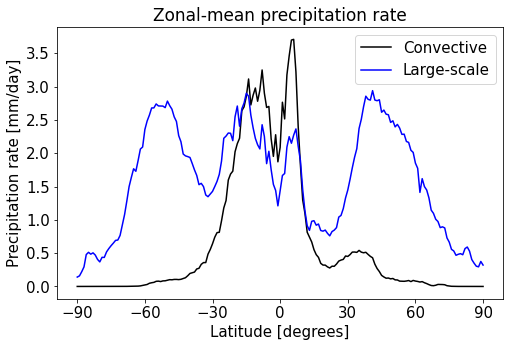

In [35]:
fig = plt.figure( figsize=(8,5) )
ax = fig.add_subplot(1,1,1)

# Plot global monthly CO emissions
ax.plot( Z_coord, Zmean_PRECC, 'k-', label='Convective' )
ax.plot( Z_coord, Zmean_PRECL, 'b-', label='Large-scale' )

# === Polish the plot === 
# Set x-axis ticks
ax.set_xticks( [-90,-60,-30,0,30,60,90] )
# Font size
plt.setp( ax.get_xticklabels(), fontsize=15 )
plt.setp( ax.get_yticklabels(), fontsize=15 )
# Add x & y axis titles
ax.set_xlabel( 'Latitude [degrees]', fontsize=15 )
ax.set_ylabel( 'Precipitation rate [mm/day]', fontsize=15 )
# Add a plot title
ax.set_title( 'Zonal-mean precipitation rate', fontsize=17 )

# Add a legend
ax.legend( fontsize=15, loc=0 )